# Data Science Exercise

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("customer-data.csv")

In [3]:
df.head()

,CustomerID,Timestamp,PurchaseValue
0,5611860a94204a4078659f1667372cc4,2017-02-09T18:31:00Z,4.72
1,07b260307114f9cffc5601eb7ad4b565,2017-06-28T19:26:00Z,5.33
2,1ede55062d0d68c70fc4d355a5328d11,2017-07-28T17:47:00Z,5.35
3,42b8e86e8da5e35628bcdc146c358665,2016-12-17T22:59:00Z,6.00
4,1047f2787b7efc759d7ffcbc40ef7e19,2016-12-05T17:23:00Z,6.28


In [4]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y/%m/%d %H:%M').dt.date

In [5]:
begin = df['Timestamp'].min()
end = df['Timestamp'].max()
print("The earliest date is {} | The latest date is {}".format(begin, end))

The earliest date is 2016-11-30 | The latest date is 2017-12-06


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
CustomerID       49945 non-null object
Timestamp        49945 non-null object
PurchaseValue    49945 non-null float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [7]:
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(transactions=df,
                                             customer_id_col='CustomerID', 
                                             datetime_col='Timestamp', 
                                             monetary_value_col='PurchaseValue',
                                             observation_period_end='2017-12-06',
                                             freq='D').reset_index()

In [8]:
summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280
1,00028502859fd7e111d88c20456b59d5,0.0,0.0,342.0,0.000
2,000306d200fd6e9b03de48d15348f5c2,0.0,0.0,33.0,0.000
3,0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065
4,000784b838b807ad589d4bc69c0c562f,0.0,0.0,210.0,0.000


## Warmup/basic python:
### 1) Implement the modified BG model from the lifetimes package using the data we provided.

In [9]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transactions=df,
                                                   customer_id_col='CustomerID', 
                                                   datetime_col='Timestamp',
                                                   calibration_period_end='2017-07-12', # 2/3rds between beginning and end dates
                                                   observation_period_end='2017-12-06',
                                                   freq='D',
                                                   monetary_value_col='PurchaseValue').reset_index()

In [10]:
summary_cal_holdout.head()

,CustomerID,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
0,0001117ff1305c1fe840697166e61564,1.0,11.0,197.0,87.2800,0.0,0.00,147
1,00028502859fd7e111d88c20456b59d5,0.0,0.0,195.0,0.0000,0.0,0.00,147
2,0003f3458a6e7b495a975c2d9ddda559,1.0,2.0,196.0,76.6300,1.0,99.50,147
3,000784b838b807ad589d4bc69c0c562f,0.0,0.0,63.0,0.0000,0.0,0.00,147
4,000ad0f90e9fcb6ff5a0bc480cccbdb3,4.0,52.0,53.0,87.6675,1.0,798.24,147


In [11]:
from lifetimes import ModifiedBetaGeoFitter

mbg = ModifiedBetaGeoFitter(penalizer_coef=0.0)
mbg.fit(frequency=summary_cal_holdout['frequency_cal'],
        recency=summary_cal_holdout['recency_cal'], 
        T=summary_cal_holdout['T_cal'])

<lifetimes.ModifiedBetaGeoFitter: fitted with 16182 subjects, a: 0.77, alpha: 72.39, b: 1.57, r: 0.87>

In [12]:
mbg.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.869037,0.075572,0.720917,1.017158
alpha,72.385291,4.552203,63.462974,81.307608
a,0.767569,0.080816,0.609170,0.925968
b,1.571636,0.284603,1.013814,2.129457


In [13]:
summary_cal_holdout.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,16182.000000,16182.000000,16182.000000,16182.000000,16182.000000,16182.000000,16182.0
mean,0.707947,27.723829,119.980967,79.240779,0.622605,76.526199,147.0
std,1.489716,53.013781,69.175899,158.124312,1.302715,166.416334,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,147.0
25%,0.000000,0.000000,58.000000,0.000000,0.000000,0.000000,147.0
50%,0.000000,0.000000,120.000000,0.000000,0.000000,0.000000,147.0
75%,1.000000,27.000000,186.000000,113.686250,1.000000,99.467500,147.0
max,49.000000,224.000000,224.000000,2907.800000,46.000000,3420.700000,147.0


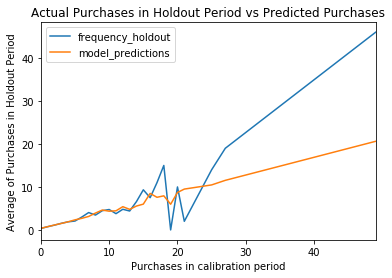

In [14]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(mbg, summary_cal_holdout, n=50)
plt.show()

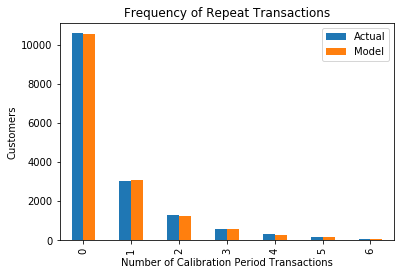

In [15]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(mbg)
plt.show()

### 2) List the 100 customers predicted to make the most purchases over the next 12 months.

In [16]:
t=365
summary['pred_purchases'] = mbg.conditional_expected_number_of_purchases_up_to_time(t=t,
                                                                                    frequency=summary['frequency'],
                                                                                    recency=summary['recency'],
                                                                                    T=summary['T'])

In [17]:
summary[['CustomerID', 'pred_purchases']].sort_values(by='pred_purchases', ascending=False).head(100)

,CustomerID,pred_purchases
15336,a5fadc51b1ae844ad9a70ad3cfa46a64,61.483878
6716,48a503edbaded96a3be27deee11967a1,29.277651
14705,9f447f9415a380ac2eeee7df49c6ee7e,24.116376
8831,5f01420f0edda6555df5ce1cc62b986c,23.150874
13047,8d2ce54737dd404d20cadf1405d46dc8,21.807302
15357,a62a17bb46864da2c6da691d838971b3,19.775169
5479,3b11478939967e896ae2619615650f97,19.339583
3941,2ad9a83ee23110d8c2f4c01600b94f20,18.908355
10926,75fda9ea22086bf3814ff8c3f53de8ca,18.571341
4470,30aa99d3357244cf38ca04eadef1473a,17.564054


### 3) List the 100 customers predicted to spend the most over the next 12 months.

In [18]:
returning_customers_summary = summary[summary['frequency']>0]
returning_customers_summary.head()

,CustomerID,frequency,recency,T,monetary_value,pred_purchases
0,0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280,0.194663
3,0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065,1.556940
5,0008e6b90a8f191089e8a0757fabf968,1.0,69.0,77.0,145.540,2.316792
6,00090b9fa28029c4839ca0a0306b6b11,1.0,61.0,82.0,349.440,2.161837
7,000ad0f90e9fcb6ff5a0bc480cccbdb3,5.0,68.0,200.0,229.782,0.863283


Confirm Gamma-Gamma submodel assumption of independence between monetary value and purchase frequency.

In [19]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.042791
frequency,0.042791,1.000000


In [20]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(frequency=returning_customers_summary['frequency'],
        monetary_value=returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 9647 subjects, p: 4.57, q: 3.65, v: 135.88>

In [21]:
summary['pred_clv'] = ggf.customer_lifetime_value(transaction_prediction_model=mbg, 
                                                  frequency=summary['frequency'], 
                                                  recency=summary['recency'],
                                                  T=summary['T'], 
                                                  monetary_value=summary['monetary_value'],
                                                  time=12,
                                                  freq="D")

In [22]:
summary[['CustomerID', 'pred_clv']].sort_values(by='pred_clv', ascending=False).head(100)

,CustomerID,pred_clv
15336,a5fadc51b1ae844ad9a70ad3cfa46a64,24788.383849
18747,ca2202a96c2de6ca6b8a37a4a73fa730,16919.328064
20502,dca76db00cc59dfbcdcc97c8bbc7f9f1,10323.236506
8399,5ac5ed64cd99ed2a8403b7a927e644ef,9066.358529
9000,60c19a709e3ced2d16d7100eb1069df5,8534.193337
8831,5f01420f0edda6555df5ce1cc62b986c,6430.500963
840,089ecc49200cfe79584d0bec2a3cf8c0,6331.232894
10770,742d5a52d4df7cb14246d7f390de5d8a,6316.257136
21927,eba458987dc67827871c1d4d92e646e1,6205.817645
15442,a719d6643a7832535de9aded2f467825,6194.385123


## Analysis:

### 4) Explain the statistical assumptions that the model makes. Do you think those assumptions are valid for a model of a customer buying widgets from an ecommerce store?

Lets first identify what the assumptions of modified BG/NBD are:
*  The number of transactions made by a customer follow a Poission process. Time between transactions follow a exponential distribution with transaction rate $\lambda$.
* Transaction rate $\lambda$ follows a gamma distribution.
* Immediately after a transaction, a customer is inactive with probability p. Customer dropout is distributed across transactions according to a shifted geometric distribution.
* Customer inactivity probability p follows a beta distribution.
* Transaction rate and dropout probability vary independently across customers.

Part one of the first assumption is the number of transactions a customer makes follows a Poission process. This is where individual transactions are independent from each other, the transaction rate is constant and two transactions cannot occur simultaneously. The second part describes the time between transaction to be exponential where customers make many short repeat purchases rather than few longer repeat purchases. The second assumption describes the transaction rate as a gamma distribution. The third assumption differs from the Pareto/NBD assumption of customer inactivity. Customer inactivity is determined immediately after a transaction as a probability p. With each additional transaction, a customer has a lower probability of becoming inactive. While few transactions increases the probability of customer inactivity. The fouth assumption being that p follows a beta distribution with $\alpha$ and $\beta$ as pdf parameters. While the last assumption is independence between transaction rate $\lambda$ and dropout probability p for each customer.

The assumptions are valid for a model of a customer buying widgets. Buying widgets from an ecommerce store is non-contractual (inactivity is unknown) and continuous (time between transactions are not fixed), unlike a subscription which is contractual (inactivity is known) and discrete (time between transactions are fixed). In most cases, similar to other ecommerce stores or online retailers, time between transactions are short, resulting in short term repeat purchases rather than long term continual repeat purchases. This behavior follows the exponential distribution. The modified BG/NBD model takes into account customer purchasing behavior and the probability of inactivity given their purchasing history. There is still the probability that the customer will return, but uncertain when. If a customer makes many purchases over time, this customer is more likely active. For the last assumption, independence between transaction rate and dropout probability, customers buying widgets may vary in how often they make transactions. A customer could stop returning after every transaction given their dropout probability.

## Write a simulation:

### 5) Simulate how many customers are alive after 10 days, 1 year, 10 years and 100 years and how many purchases they made in that time using the modified BG model. Use a random sample of 100 customers and show the results for 1 run of your simulation. We've outlined a possible approach below:
* a) Generate a random sample of 100 customers.
* b) Simulate how each customer makes purchases over time.
* c) Count how many purchases the customers have made in 10 days.
* d) Count how many customers are alive after 10 days.
* e) Repeat b-d for 1 year 10 years, 100 years.
* f) Tip: Your simulation should show a different number of customers alive each time the code is evaluated. (Often it is interesting to look at this range of values, but for this exercise, we are only looking for you to show us the result of one run.)

In [23]:
from lifetimes.generate_data import modified_beta_geometric_nbd_model

times = [10, 365, 3650, 36500] # periods in terms of days
r, alpha, a, b = mbg.summary['coef']
size = 100

for duration in times:
    generated_customers = modified_beta_geometric_nbd_model(T=duration, 
                                                            r=r, 
                                                            alpha=alpha,
                                                            a=a,
                                                            b=b,
                                                            size=size)
    print("-----------------------------------------------------------------")
    print("Duration: {}".format(duration))
    print("Number of Purchases: {} | Number of Customers Alive: {}".format(generated_customers['frequency'].sum(), 
                                                                           generated_customers['alive'].sum()))
    print("-----------------------------------------------------------------")

-----------------------------------------------------------------
Duration: 10
Number of Purchases: 9.0 | Number of Customers Alive: 64.0
-----------------------------------------------------------------
-----------------------------------------------------------------
Duration: 365
Number of Purchases: 125.0 | Number of Customers Alive: 35.0
-----------------------------------------------------------------
-----------------------------------------------------------------
Duration: 3650
Number of Purchases: 563.0 | Number of Customers Alive: 10.0
-----------------------------------------------------------------
-----------------------------------------------------------------
Duration: 36500
Number of Purchases: 1265.0 | Number of Customers Alive: 3.0
-----------------------------------------------------------------


## Analysis of results of questions 1-5:

### 6) The model works well in some ways and poorly in others for the data we provide. Explain what it does well and what it does poorly.

The model does well when predicting customer purchasing behavior with smaller frequencies. From the figure below, the model does well at the beginning where frequencies are small. We then see the model generalize rather well while also responding to minor changes. These results are due to the majority of observations being smaller frequencies than larger frequencies. As there are fewer observations on the larger frequencies, the model struggles to predict customer purchasing behavior. This model behavior can be seen with the lack of congruence towards the right of the figure. As a result of the models inability to predict customer purchasing behavior of larger frequencies can also affect how CLV is predicted. With varying predictions for large frequencies, CLV predictions will be underestimated.

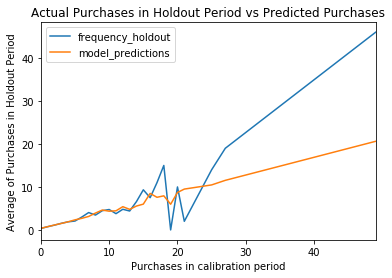

In [24]:
plot_calibration_purchases_vs_holdout_purchases(mbg, summary_cal_holdout, n=50)
plt.show()

### 7) What are one or two ideas that could address the deficiencies of the model? (No need to implement, just describe.)

An idea is to add/adjust model fit weights. In the documentation the weights parameter calculates the log-likelihood for given patterns in the data rather than individual calculations. This would compensate for the lack of observations as well as focus on particular patterns in the data. The model would be able to predict customer purchasing behavior, as well as better tune CLV predictions for those with higher frequencies.

## Explain, independent of questions 1-7:

### 8) Suppose the intended use of the modified BG model is binning customers into one of the following categories: highly likely to purchase in the next year, somewhat likely to purchase in the next year, unlikely to purchase in the next year, highly unlikely to purchase in the next year. Suppose you want to compare this model with a model your colleague is proposing. How would you evaluate the two models? Do not implement, but do show a mockup of the results of your evaluation.

Before evaluating both models I would compare model assumptions and determine which model would best fit the given situation.

A possible way to bin customers is by predicting whether a customer is alive after a given period. If the customer falls into a certain percentage interval, for example, [0.25, 0.50, 0.75, 1], the model then bins those customers into their respective categories.

Steps for Model Comparison:
* Generate simulated dataset. This dataset would consist of observations generated by both models with varying parameters.
* Generate multiple datasets for training and testing.
* Split the data into calibration and holdout data. 
* Train both models on the calibration data. 
* Fit holdout data to both models and predict customer bins.
* With both models trained and tested, use an evaluation metric such as mean squared error.
* Aggregate all results from other simulated data and compare both models. In the case of mean squared error, we select the model with the lowest error.
* Can also look into individual datasets and observe patterns that both models did well or poorly.

### Simple Mockup

In [25]:
from numpy import random
from sklearn.metrics import mean_squared_error

probability_alive = [random.random() for i in range(0, 10)]
model_1_pred = [random.random() for i in range(0, 10)]
model_2_pred = [random.random() for i in range(0, 10)]

model_1_error = mean_squared_error(y_true=probability_alive, y_pred=model_1_pred)
model_2_error = mean_squared_error(y_true=probability_alive, y_pred=model_2_pred)

print("Model 1 MSE: {} | Model 2 MSE: {}".format(model_1_error, model_2_error))

Model 1 MSE: 0.1667565038565583 | Model 2 MSE: 0.08376960320078862
